**COVID-19: Measuring Industry Impact**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


The coronavirus has caused untold disruption throughout the world in early 2020. Not only has the pandemic inflicted significant loss of life, it has wreaked havoc on businesses across many sectors. Indeed, commentators have gone so far as to name Monday 9th March “Black Monday” as the S&P 500 and Dow Jones each sunk nearly 8% amid economic stagnation.



# 1. The Case Study

In this tutorial, we will focus on the S&P 500 companies. We will start by collecting the following data :
* Stock prices in 3 different dates (January 1st, April 1st and August 1st) 
* Number of outstanding shares for each company
* Industry/Sector where the companies operate (following the GICS classification)

#2. Collecting and Storing Stocks Data

In [2]:
%matplotlib inline

import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
#from gspread_pandas import Spread, Client

import seaborn as sns 
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Getting the list of S&P 500 companies from Wikipedia**

As a first step in the data collection effort, we need to get the list of S&P 500 companies.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
stocks_df = pd.read_html(url, header=0)[0]
stocks_df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


The most important data that we need is:
* Symbol: Stock Symbol 
* Security: Name of the company
* GICS Sector: Sector where the company operates following the Global Industry Classification Standard (GICS).
* GICS Sub Industry: Sub industry where the company operates following the Global Industry Classification Standard (GICS).


In [4]:
len(stocks_df)

505

In [5]:
stocks_df['GICS Sector'].value_counts()


Industrials               73
Information Technology    71
Financials                66
Health Care               62
Consumer Discretionary    61
Consumer Staples          33
Real Estate               31
Utilities                 28
Materials                 28
Communication Services    26
Energy                    26
Name: GICS Sector, dtype: int64

In [6]:
stocks_df['GICS Sub Industry'].value_counts()


Health Care Equipment            20
Industrial Machinery             14
Semiconductors                   13
Electric Utilities               13
Packaged Foods & Meats           12
                                 ..
Leisure Products                  1
Drug Retail                       1
Metal & Glass Containers          1
Brewers                           1
Agricultural & Farm Machinery     1
Name: GICS Sub Industry, Length: 125, dtype: int64

In [7]:
stocks_df["Price_1_1"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "1/1/2020"),2,2)')
stocks_df["Price_1_4"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "1/4/2020"),2,2)')
stocks_df["Price_1_8"] = stocks_df["Symbol"].apply(lambda x: '=INDEX(GOOGLEFINANCE("' + x + '","price", "1/8/2020"),2,2)')

In [8]:
stocks_df["Shares"] = stocks_df["Symbol"].apply(lambda x: '=GOOGLEFINANCE("' + x + '","shares")')
stocks_df.head()


,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,Price_1_1,Price_1_4,Price_1_8,Shares
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902,"=INDEX(GOOGLEFINANCE(""MMM"",""price"", ""1/1/2020""...","=INDEX(GOOGLEFINANCE(""MMM"",""price"", ""1/4/2020""...","=INDEX(GOOGLEFINANCE(""MMM"",""price"", ""1/8/2020""...","=GOOGLEFINANCE(""MMM"",""shares"")"
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,"=INDEX(GOOGLEFINANCE(""ABT"",""price"", ""1/1/2020""...","=INDEX(GOOGLEFINANCE(""ABT"",""price"", ""1/4/2020""...","=INDEX(GOOGLEFINANCE(""ABT"",""price"", ""1/8/2020""...","=GOOGLEFINANCE(""ABT"",""shares"")"
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),"=INDEX(GOOGLEFINANCE(""ABBV"",""price"", ""1/1/2020...","=INDEX(GOOGLEFINANCE(""ABBV"",""price"", ""1/4/2020...","=INDEX(GOOGLEFINANCE(""ABBV"",""price"", ""1/8/2020...","=GOOGLEFINANCE(""ABBV"",""shares"")"
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,"=INDEX(GOOGLEFINANCE(""ABMD"",""price"", ""1/1/2020...","=INDEX(GOOGLEFINANCE(""ABMD"",""price"", ""1/4/2020...","=INDEX(GOOGLEFINANCE(""ABMD"",""price"", ""1/8/2020...","=GOOGLEFINANCE(""ABMD"",""shares"")"
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,"=INDEX(GOOGLEFINANCE(""ACN"",""price"", ""1/1/2020""...","=INDEX(GOOGLEFINANCE(""ACN"",""price"", ""1/4/2020""...","=INDEX(GOOGLEFINANCE(""ACN"",""price"", ""1/8/2020""...","=GOOGLEFINANCE(""ACN"",""shares"")"


In [9]:
stocks_df.to_excel("stock-data.xlsx")
stocks_df = pd.read_csv("/content/drive/My Drive/Data_Assignment_Covid19/stock-data.csv")


In [10]:
stocks_df.head()


,Unnamed: 0,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,Price_1_1,Price_1_4,Price_1_8,Shares
0,0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902,180,"133,14","150,41",576019000
1,1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,"86,95","76,57","100,68",1770530000
2,2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),"89,55","73,42","95,94",1764833000
3,3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,"168,81","144,48","308,35",45047000
4,4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,"210,15","154,68","227,18",636197000


# 4. Analyzing the data

In [11]:
stocks_df  = stocks_df.replace(",", ".", regex=True)
stocks_df[["Price_1_1", "Price_1_4", "Price_1_8", "Shares"]] = stocks_df[["Price_1_1", "Price_1_4", "Price_1_8", "Shares"]].astype(float)

In [12]:
#Adding Market Cap Data
stocks_df["Marketcap_1_1"] = stocks_df["Price_1_1"] * stocks_df["Shares"]
stocks_df["Marketcap_1_4"] = stocks_df["Price_1_4"] * stocks_df["Shares"]
stocks_df["Marketcap_1_8"] = stocks_df["Price_1_8"] * stocks_df["Shares"]
print(stocks_df["Marketcap_1_1"])

0      1.036834e+11
1      1.539476e+11
2      1.580408e+11
3      7.604384e+09
4      1.336968e+11
           ...     
500    3.079404e+10
501    1.382253e+10
502    3.089186e+10
503    8.599006e+09
504    6.373595e+10
Name: Marketcap_1_1, Length: 505, dtype: float64


In [13]:
# Percentage Change from January 1st to April 1st 
stocks_df["PercentageChange_1_4_1_1"] = (stocks_df["Price_1_4"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100
# Percentage Change from  April 1st  to  August 1st 
stocks_df["PercentageChange_1_8_1_4"] = (stocks_df["Price_1_8"] - stocks_df["Price_1_4"]) / stocks_df["Price_1_4"]*100
# Percentage Change from January 1st to August 1st 
stocks_df["PercentageChange_1_8_1_1"] = (stocks_df["Price_1_8"] - stocks_df["Price_1_1"]) / stocks_df["Price_1_1"]*100

**Change in the total market cap of the S&P 500**

In [14]:
a = stocks_df["Marketcap_1_4"] - stocks_df["Marketcap_1_1"]
a = a.sum() / 10**9
print(a)

-6660.385765646641


In [15]:
a = stocks_df["Marketcap_1_8"] - stocks_df["Marketcap_1_4"]
a = a.sum() / 10**9
print(a)

7134.9932972724


In [16]:
a = stocks_df["Marketcap_1_8"] - stocks_df["Marketcap_1_1"]
a = a.sum() / 10**9
print(a)

456.56970328576017


The S&P 500 lost 6,6 trillion USD from January 1st to April 1st, but it got back 7.1 trillion from April 1st to August 1st.

**Change in the total market cap by sector**


In [17]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_1_4"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9


GICS Sector
Financials               -1299.816369
Information Technology   -1148.222922
Industrials               -781.125024
Consumer Discretionary    -656.135912
Health Care               -634.998289
Energy                    -628.265643
Communication Services    -617.054719
Consumer Staples          -298.397165
Materials                 -209.919810
Real Estate               -190.017675
Utilities                 -163.171664
dtype: float64

At the 2020 bottom of the S&P 500 (April 1st), the Information Technology and Financials sectors had the largest drop in total market cap (compared to January 1st) with 1.3 trillion and 1.1 trillion respectively.

In [18]:
(stocks_df.groupby("GICS Sector").sum()["Marketcap_1_8"] - stocks_df.groupby("GICS Sector").sum()["Marketcap_1_1"]).sort_values() / 10**9


GICS Sector
Financials                -788.490849
Energy                    -475.908582
Industrials               -300.712617
Real Estate                -52.471633
Utilities                  -50.495636
Materials                   -9.537168
Consumer Staples             7.746028
Communication Services     150.732835
Health Care                199.600057
Consumer Discretionary     453.682302
Information Technology    1373.723367
dtype: float64

As of August 1st, we can see that the Financials and Energy sector had the largest drop in total market cap compared to January 1st.

**Ranking of companies by percentage change of stock prices**

In [19]:
stocks_df.sort_values(by=["PercentageChange_1_8_1_1"])[["Security", "PercentageChange_1_8_1_1"]].head(5)


,Security,PercentageChange_1_8_1_1
348,Norwegian Cruise Line Holdings,-77.800442
87,Carnival Corp.,-74.527383
130,Coty. Inc,-66.696833
406,Royal Caribbean Group,-64.805050
459,United Airlines Holdings,-64.486294


We can see from the table above that the companies that are hardest hit are the 2 major cruises companies: Norwegian Cruise Line Holdings, Carnival Corp., Royal Caribbean Cruises Ltd. These companies saw drops in their stock price of over 70%.



In [20]:
print(sum(stocks_df["PercentageChange_1_8_1_1"] < 0))
print(sum(stocks_df["PercentageChange_1_8_1_1"] > 0))

311
192


**Percentage Change of stock priced by sector**

In [21]:
stocks_df.groupby("GICS Sector").mean()['PercentageChange_1_8_1_1'].sort_values()


GICS Sector
Energy                   -43.276168
Financials               -19.505009
Real Estate              -15.835272
Consumer Discretionary   -13.106663
Industrials               -8.401737
Utilities                 -8.136877
Materials                 -7.499641
Communication Services    -3.480520
Consumer Staples          -0.232584
Information Technology     6.564060
Health Care               11.453025
Name: PercentageChange_1_8_1_1, dtype: float64

We can see that the energy sector was the hardest hit with a 43% average drop in stock prices.

Below we can visualize a boxplot of the 11 sectors' percentage change in stock prices from January 1st to August 1st.

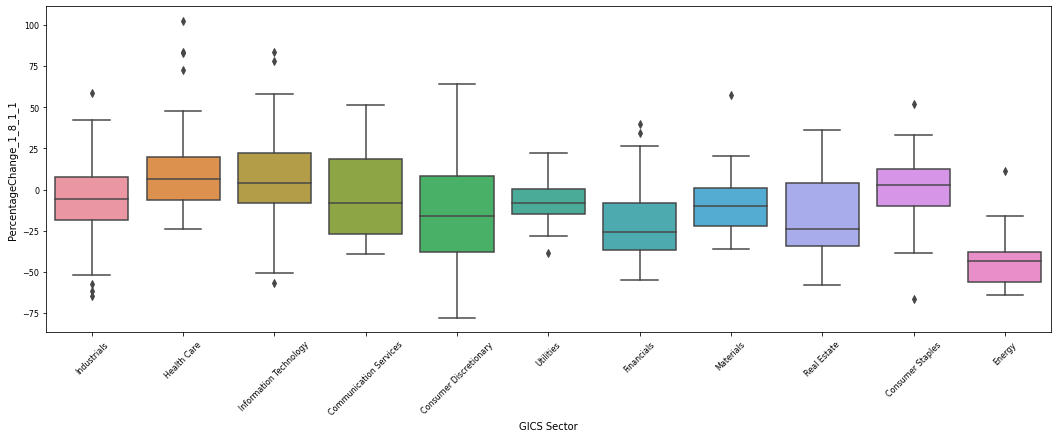

In [22]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
plt.xticks(rotation=45)
sns.boxplot(x="GICS Sector", y="PercentageChange_1_8_1_1", data=stocks_df)

In [23]:
stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_1'].sort_values()


GICS Sub Industry
Hotels. Resorts & Cruise Lines        -58.987812
Airlines                              -55.250732
Oil & Gas Equipment & Services        -49.964731
Casinos & Gaming                      -46.165928
Oil & Gas Exploration & Production    -44.682160
                                         ...    
Household Products                     27.348914
Wireless Telecommunication Services    35.996946
Systems Software                       37.300219
Interactive Home Entertainment         38.185177
Gold                                   57.681629
Name: PercentageChange_1_8_1_1, Length: 125, dtype: float64

In [24]:
print(sum(stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_1'] < 0))
print(sum(stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_1'] > 0))

75
50


[Text(0, 0.5, 'Perentage Change')]

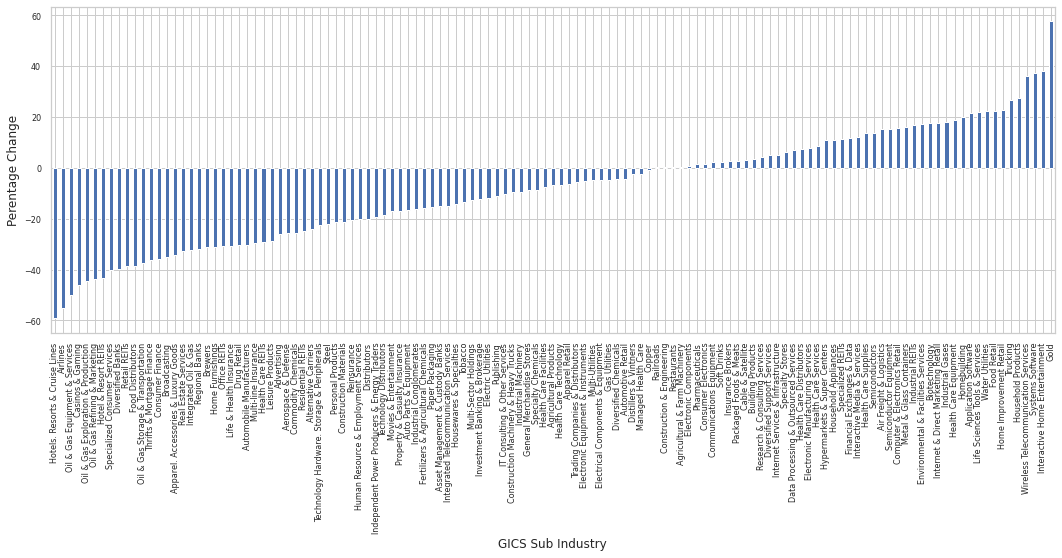

In [46]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
ax = stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_1'].sort_values().plot.bar()
ax.set(ylabel='Perentage Change')

[Text(0, 0.5, 'Perentage Change')]

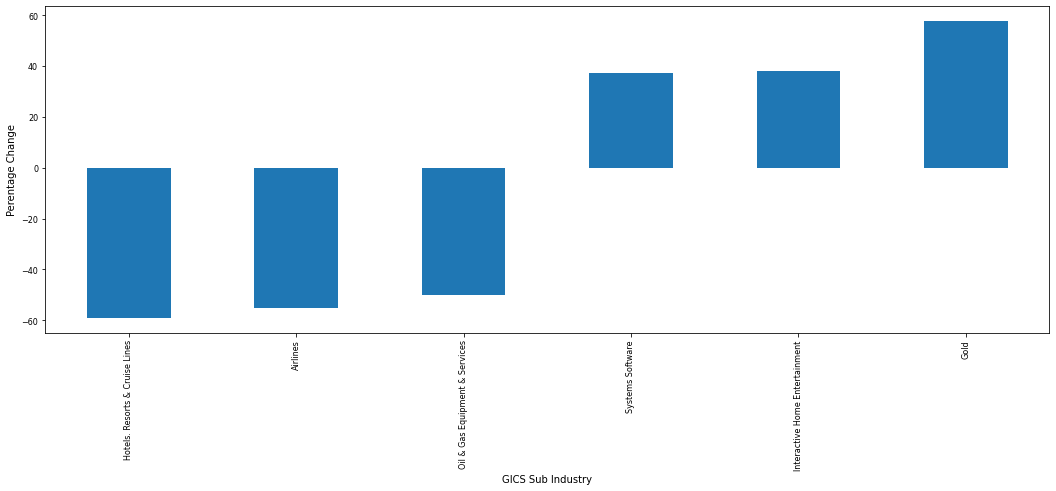

In [26]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
stock_data_temp = stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_1'].sort_values()
stock_data_top = pd.concat([stock_data_temp.head(3), stock_data_temp.tail(3)])
ax = stock_data_top.plot.bar()
ax.set(ylabel='Perentage Change')



W we look at the average percentage change in stock prices by Sub Industry; we can see that the travel related industries, Oil & Gas and Department Stores were the hardest hit. 


[Text(0, 0.5, 'Perentage Change')]

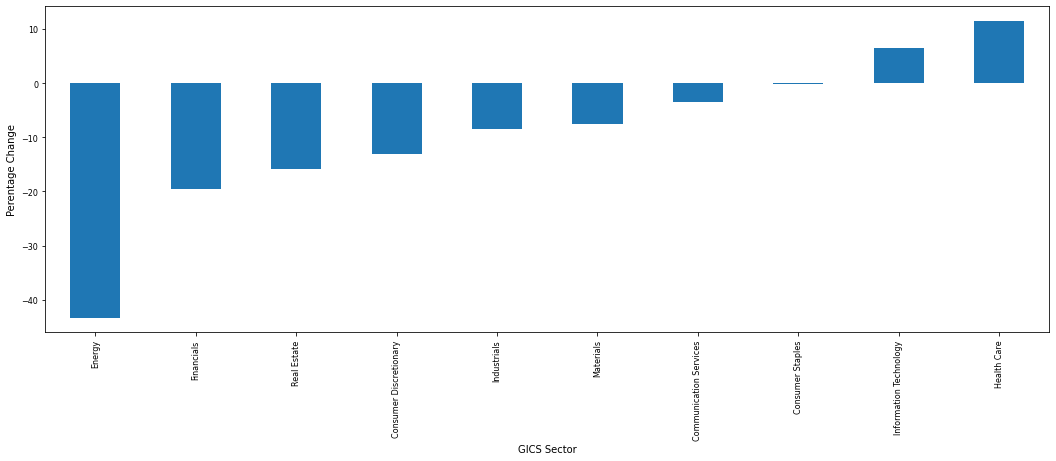

In [27]:
plt.figure(figsize=(18, 6))
plt.tick_params('both', labelsize='8')
#sns.set()
top = stocks_df.groupby("GICS Sector").mean()['PercentageChange_1_8_1_1'].sort_values()
top_data = pd.concat([top.head(),top.tail()])
ax= top_data.sort_values().plot.bar()
ax.set(ylabel='Perentage Change')

**Percentage Change of stock priced by sector (From April 1st to August 1st)**

In [28]:
stocks_df.groupby("GICS Sector").mean()['PercentageChange_1_8_1_4'].sort_values()


GICS Sector
Utilities                 15.565503
Consumer Staples          18.300198
Real Estate               20.764129
Financials                29.580881
Communication Services    34.381085
Industrials               34.426243
Materials                 35.924336
Health Care               36.141061
Information Technology    40.068806
Consumer Discretionary    49.633833
Energy                    52.630261
Name: PercentageChange_1_8_1_4, dtype: float64

**Percentage Change of stock priced by Sub Industry (From April 1st to August 1st)**

In [29]:
stocks_df.groupby("GICS Sub Industry").mean()['PercentageChange_1_8_1_4'].sort_values()

GICS Sub Industry
Drug Retail                       -4.531722
Brewers                           -2.747688
Hotel & Resort REITs               0.291829
Thrifts & Mortgage Finance         3.488372
Leisure Products                   6.835046
                                    ...    
Apparel Retail                    71.391468
Computer & Electronics Retail     87.179963
Homebuilding                      98.353984
Household Appliances             104.230769
Copper                           107.606973
Name: PercentageChange_1_8_1_4, Length: 125, dtype: float64

**Summary**

* We can see that the travel related industries, Oil & Gas and Department Stores were the hardest hit.
* Only in Information Technology, Health Care is grow up. Detail is: gold, interactive home entertainment, Telecommuication service, Food Retail, ...

## **The effect of COVID-19 on oil price**

In [30]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt


In [31]:
oil_df = pd.read_csv("/content/drive/My Drive/Data_Assignment_Covid19/BrentOilPrices.csv")
oil_df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [32]:
oil_df['Date'] = pd.to_datetime(oil_df['Date'])
oil_df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Text(0.5, 1.0, 'Brent Oil Price Trend')

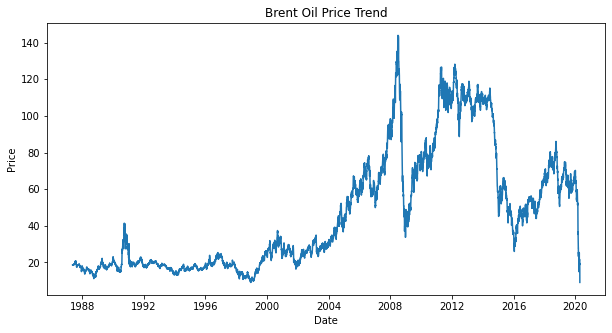

In [33]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(x='Date',y='Price',data = oil_df)
plt.title("Brent Oil Price Trend")

In [34]:
def plot_price_trend(df, start_date, end_date):
    mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
    sdf = df.loc[mask]
    plt.figure(figsize = (10,5))
    chart = sns.lineplot(x='Date',y='Price',data = sdf)
    plt.title("Brent Oil Price Trend")

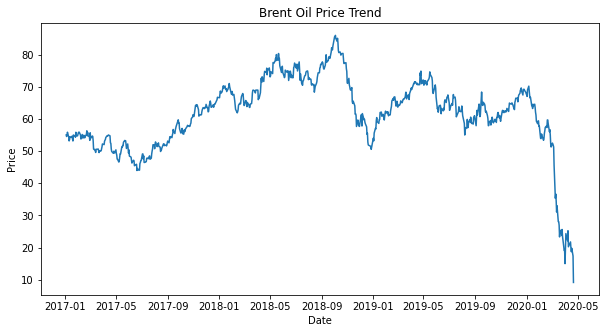

In [35]:
plot_price_trend(oil_df,'2017-01-01','2020-04-21')


## **Impact of COVID-19 on worldwide aviation**

In [36]:
from pathlib import Path
import pandas as pd

flightlist = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in Path("/content/drive/My Drive/Data_Assignment_Covid19/air_traffic").glob("flightlist_*.csv.gz")
)

In [37]:
airports_subset = [
    # # Europe
    # ["LFPG", "EGLL", "EHAM", "EDDF", "LEMD", "LIRF", "LSZH", "UUEE"],
    # # Eastern Asia
    # ["VHHH", "RJBB", "RJTT", "RKSI", "RCTP", "RPLL"],
    # Asia 
    ["YSSY", "YMML", "OMDB", "VABB", "VIDP", "WSSS"],
    # # Americas
    # ["CYYZ", "KSFO", "KLAX", "KATL", "KJFK", "SBGR"],
]

data_flights = pd.concat(
    (
        flightlist.query(f'origin == "{airport}"')
        # count the number of departing aircraft per day
        .groupby("day")
        .agg(dict(callsign="count"))
        # label the current chunk with the name of the airport
        .rename(columns=dict(callsign=airport))
        # iterate on all airports in the list hereabove
        for airport in sum(airports_subset, [])
    ),
    axis=1,
)

In [38]:
data_flights.head()

,YSSY,YMML,OMDB,VABB,VIDP,WSSS
day,,,,,,
2020-01-01 00:00:00+00:00,318,267,389,275.0,497.0,440.0
2020-01-02 00:00:00+00:00,312,278,342,291.0,463.0,399.0
2020-01-03 00:00:00+00:00,267,233,344,264.0,465.0,380.0
2020-01-04 00:00:00+00:00,270,229,396,271.0,496.0,431.0
2020-01-05 00:00:00+00:00,329,270,390,281.0,500.0,444.0


In [39]:
data_flights.tail()

,YSSY,YMML,OMDB,VABB,VIDP,WSSS
day,,,,,,
2020-05-27 00:00:00+00:00,24,16,48,22.0,90.0,44.0
2020-05-28 00:00:00+00:00,21,21,46,19.0,97.0,31.0
2020-05-29 00:00:00+00:00,20,19,40,29.0,98.0,24.0
2020-05-30 00:00:00+00:00,15,18,45,20.0,101.0,13.0
2020-05-31 00:00:00+00:00,27,13,31,20.0,87.0,35.0


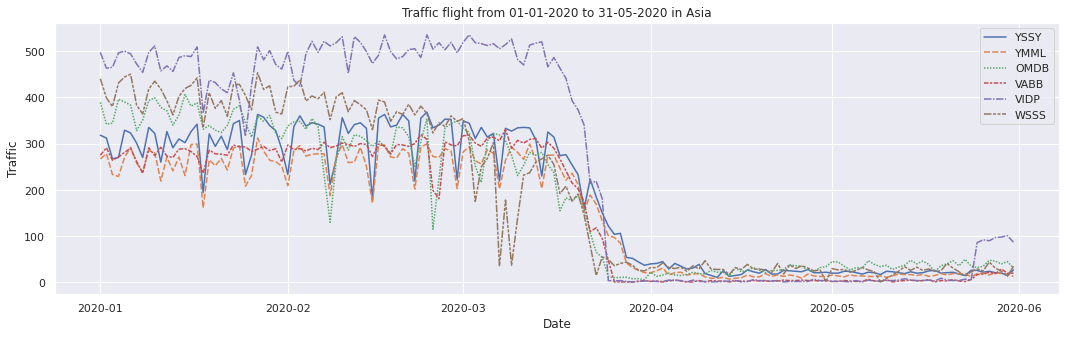

In [40]:
#data.plot.line()
#ax = sns.lineplot(data = data_flights )
sns.set()
plt.figure(figsize=(18,5))

# ax = sns.lineplot(hue="event", style="event", markers=True, dashes=False, size=(10,5), data=data_flights)
ax = sns.lineplot(hue="region", style="event",
             data=data_flights)
ax.set(xlabel='Date', ylabel='Traffic')
ax.set_title("Traffic flight from 01-01-2020 to 31-05-2020 in Asia")
plt.show()

The trend showed:

* A slow decrease from February in Asian airports (an early one in Hong-Kong);

* Airports plummetting since early day of March;

* India almost stopped all traffic (VABB, VIDP).

## **Top company technology**

In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

from datetime import datetime

In [42]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)


for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    globals()[stock] = DataReader(stock, 'yahoo', start, end)

In [43]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-08-17,3194.969971,3154.179932,3173.120117,3182.409912,2691200.0,3182.409912,AMAZON
2020-08-18,3320.000000,3205.820068,3212.000000,3312.489990,5346000.0,3312.489990,AMAZON
2020-08-19,3315.899902,3256.000000,3303.010010,3260.479980,4185100.0,3260.479980,AMAZON
2020-08-20,3312.620117,3238.000000,3252.000000,3297.370117,3332500.0,3297.370117,AMAZON
2020-08-21,3314.399902,3275.389893,3295.000000,3284.719971,3575900.0,3284.719971,AMAZON
2020-08-24,3380.320068,3257.560059,3310.149902,3307.459961,4666300.0,3307.459961,AMAZON
2020-08-25,3357.399902,3267.000000,3294.989990,3346.489990,3992800.0,3346.489990,AMAZON
2020-08-26,3451.739990,3344.570068,3351.110107,3441.850098,6508700.0,3441.850098,AMAZON
2020-08-27,3453.000000,3378.000000,3450.050049,3400.000000,4264800.0,3400.000000,AMAZON


In [44]:
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,306.968333,299.640278,302.924246,303.770793,3.698683e+07,302.381261
std,67.726381,66.060482,66.980453,67.086882,1.768355e+07,67.627940
min,206.979996,204.220001,206.429993,205.699997,1.165440e+07,203.679108
25%,260.145004,254.764996,256.979988,258.205002,2.530535e+07,256.701385
50%,294.250000,285.990005,289.315002,290.714996,3.213660e+07,288.771133
75%,326.205009,321.677498,324.240005,324.992508,4.258215e+07,323.429764
max,515.140015,500.329987,514.789978,506.089996,1.066275e+08,506.089996


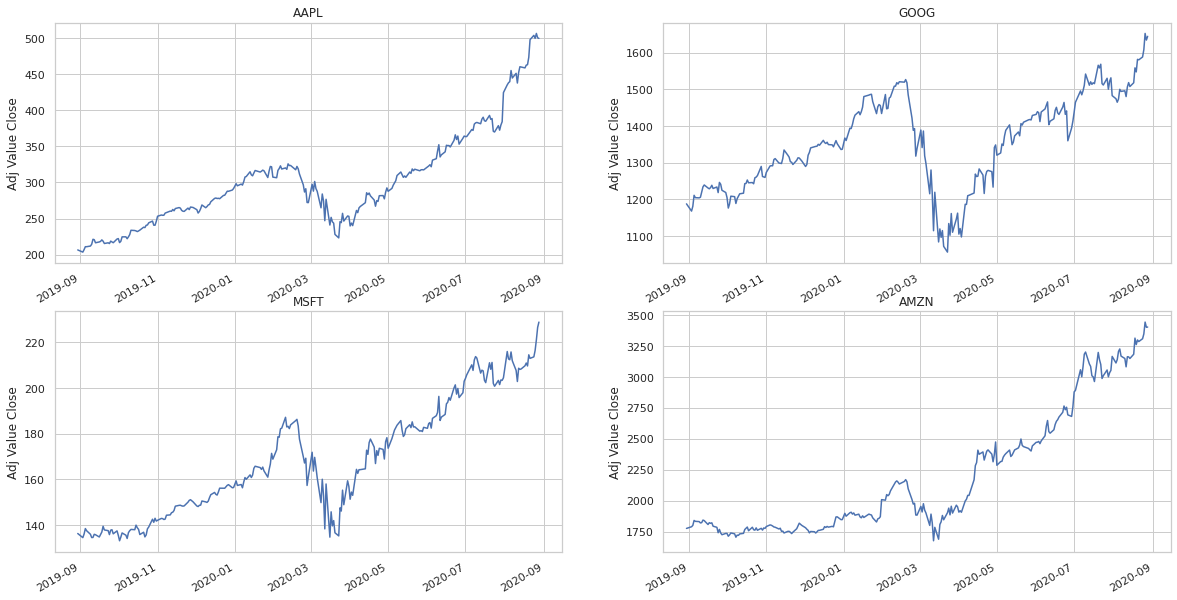

In [45]:
plt.figure(figsize=(20, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Value Close')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")
